
## Семинар 3. Модели экспоненциального сглаживания. Порядок построения и валидации модели.



### Модели Хольта-Винтерса и ETS

Для начала возьмём какие-нибудь простые данные без трендов. В нашем случае это будет один из стандартных датасетов. Используем процентные изменения в совокупном потреблении США c 1960 по 2006.

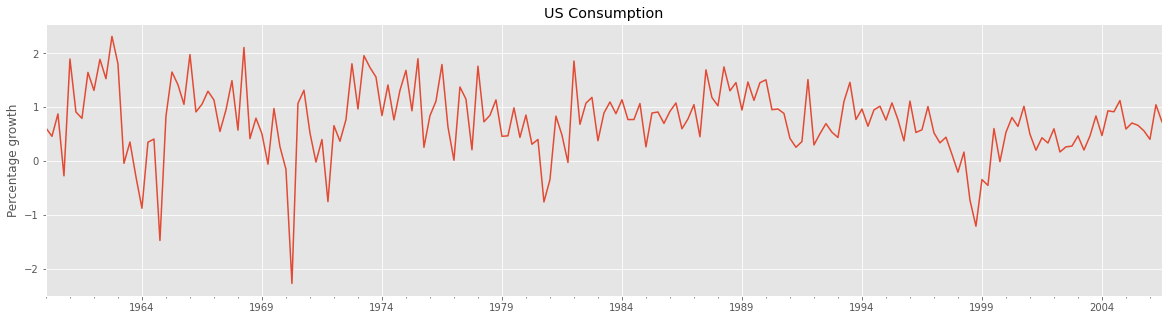

In [86]:
from sktime.datasets import load_uschange
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


y, _ = load_uschange()
y.index = pd.date_range(start="1960.01.01", periods=len(y), freq="Q").to_period()

# Если потребуются мультипликативные модели, необходимо децентрировать данные
# y = y + 10


y_train, y_test = temporal_train_test_split(y, test_size=10)

y.plot()
plt.title("US Consumption")
plt.ylabel("Percentage growth");

Импортируем модели Хольта-Винтерса и ETS. Из последнего семинара мы знаем, что эти модели в целом различаются только метедом оценки, но структурно эквивалентны. Посмотрим на простом примере, а далее будем использовать только ETS, чтобы не дублировать слишком много кода.

In [89]:

from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error



Forecast error: 0.4102590391796418


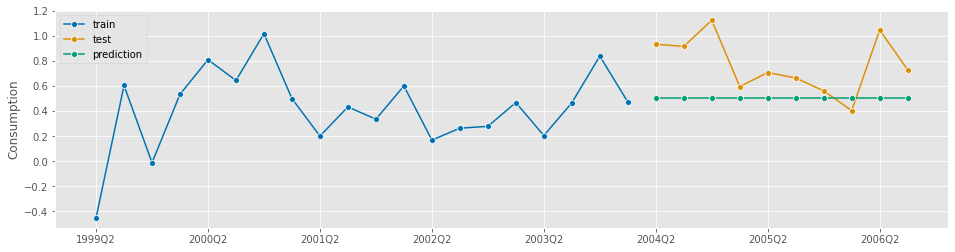

In [91]:



forecaster = ExponentialSmoothing()
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,11)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')

Как видим ниже, оценён параметр $l_0$. Вообще параметр $\alpha$ тоже где-то под капотом оценивается, но достать легко его не получилось. Похоже, этот блок допиливается. Хотя я ставил пакет пару недель назад, пришлось обновиться, чтобы заработали некоторые параметры из документации. В дальнейшем перейдём к ETS, там выдача прозрачнее.

Внимательный читатель спросит, мол, как это оценены информационные критерии, у нас же эти модели оцениваются не через правдоподобие. За точным ответом надо лезть в потроха, но с учётом того, что метод оптимизации -- SLSQP (Sequential Least SQuares Programming), ответ скорее всего прозаичнее. Можно вспомнить, что в задачах с нормальным правдоподобием (во всяком случае в плане обычной регрессии) оптимизация правдоподобия эквивалентна задаче минимизации MSE. И вообще говоря, в таком случае можно записать информационные критерии через MSE, а не через правдоподобие. Что, по видимому, здесь и сделано. Более того, вариантов записи информационных критериев существует немало, поэтому рекомендуется всегда поглядывать в документацию.

In [73]:
forecaster.get_fitted_params()

{'initial_level': 0.6911217219452713,
 'initial_slope': None,
 'initial_seasons': array([], dtype=float64),
 'aic': -158.54276073119357,
 'bic': -152.1904612660459,
 'aicc': -158.31020259165868}

In [74]:
forecaster.predict_interval()

NotImplementedError: ExponentialSmoothing does not have the capability to return prediction intervals. If you think this estimator should have the capability, please open an issue on sktime.

Теперь оценим ETS(A,N,N)-модель. Как видим, легко получается то же самое.

Forecast error: 0.4102674465656648


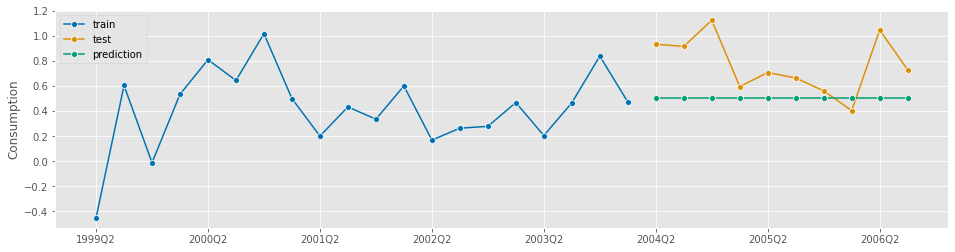

In [92]:


forecaster = AutoETS()
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,11)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')


Однако выдача ETS-модели куда приятнее. Видим, что оценка $l_o$ совпала с предыдущим случаем, но теперь доступна ещё и оценка $\alpha$.

In [76]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  177
Model:                       ETS(ANN)   Log Likelihood                -169.881
Date:                Sat, 05 Feb 2022   AIC                            345.761
Time:                        18:24:18   BIC                            355.290
Sample:                    03-31-1960   HQIC                           349.626
                         - 03-31-2004   Scale                            0.399
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.3278      0.069      4.752      0.000       0.193       0.463
initial_level       0.6910      0.471      1.468      0.142      -0.232       1.614
===================================================================================
Ljung-Box (Q):                        0.05   Jarque-Bera (JB):                22.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Теперь возьмём какие-нибудь трендированные данные.

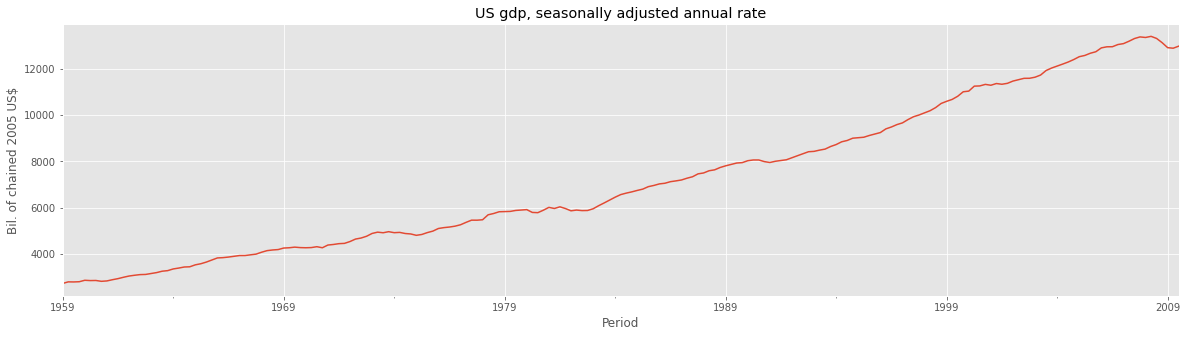

In [93]:
from sktime.datasets import load_macroeconomic

y = load_macroeconomic().realgdp
y.plot()
plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

y_train, y_test = temporal_train_test_split(y, test_size=35)

Понятное дело, что здесь уже необходимо применять модель, в которой есть трендовая компонента. Попробуем применить.

Forecast error: 0.051258516381638676


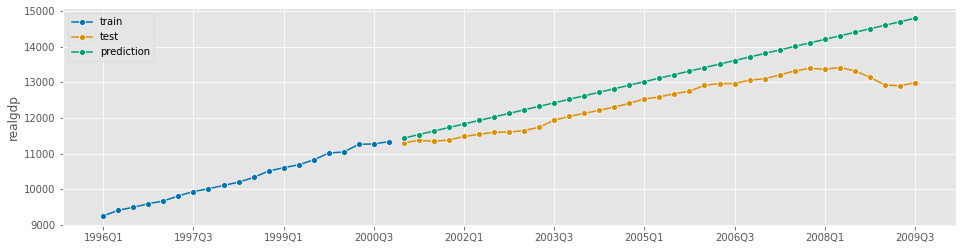

In [94]:
forecaster = AutoETS(trend="add")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
forecaster.summary()
print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')

Видим явную переоценку тренда. Попробуем дампировать

Forecast error: 0.016203035075154373


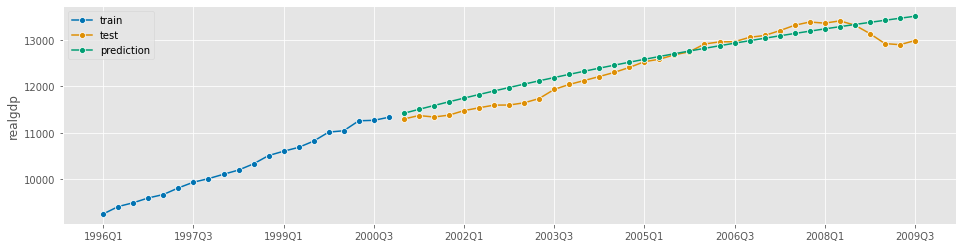

In [95]:
forecaster = AutoETS(trend="add", damped_trend=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
forecaster.summary()

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')



Мультипликативный тренд, по понятным причинам, ничего особо не изменит, так как тренд затухающий, а не экспоненциальный. Да и дамприование с мультипликативным трендом выглядит несколько противоестественно.

Forecast error: 0.016507235632117853


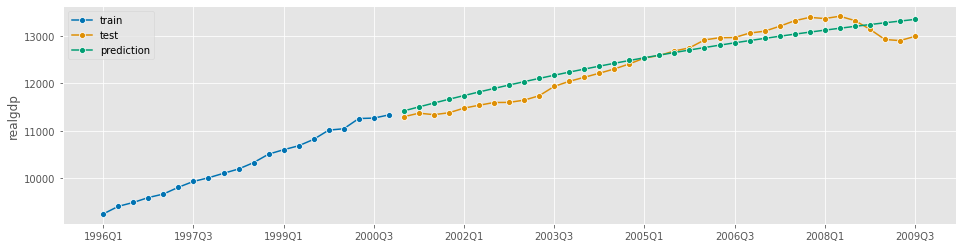

In [96]:
forecaster = AutoETS(trend="mul", damped_trend=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
forecaster.summary()

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')



Теперь рассмотрим данные с трендом и сезонностью. Возьмём самый стандартный и избитый (но всё ещё прекрасный) пример с авиаперевозками с 1949 по 1960.

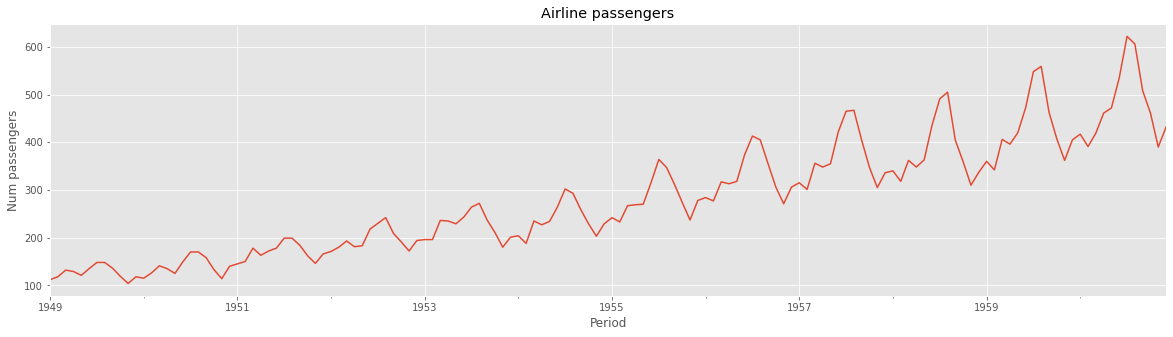

In [100]:
from sktime.datasets import load_airline

y = load_airline()
y.plot()
plt.title('Airline passengers')
plt.ylabel('Num passengers')

y_train, y_test = temporal_train_test_split(y, test_size=0.2)

Здесь у нас уже очевидно имеется сезонность. И более того, восходящий, схожий с экспоненциальным, тренд. Можно попробовать также использовать мультипликативную сезонность и мультипликативную ошибку, так как с ростом тренда растут колебания сезонности и, скорее всего, случайные шоки. Но сначала для сравнения возьмём аддитивную.

Forecast error: 0.068314857741715


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(AAA)   Log Likelihood                -441.531
Date:                          Sat, 05 Feb 2022   AIC                            919.062
Time:                                  19:05:43   BIC                            968.471
Sample:                              01-31-1949   HQIC                           939.117
                                   - 07-31-1958   Scale                          126.586
Covariance Type:                         approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2612      0.047      5.538      0.000       0.169       0.354
smoothing_trend      2.612e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.7388      0.073     10.169      0.000       0.596       0.881
initial_level         109.7597      5.968     18.392      0.000      98.063     121.456
initial_trend           2.2551      0.345      6.539      0.000       1.579       2.931
initial_seasonal.0     -2.6051      9.350     -0.279      0.781     -20.931      15.721
initial_seasonal.1    -19.2803      9.379     -2.056      0.040     -37.662      -0.899
initial_seasonal.2     -4.8426      9.303     -0.521      0.603     -23.076      13.391
initial_seasonal.3     13.9935      9.292      1.506      0.132      -4.219      32.206
initial_seasonal.4     28.1560      9.291      3.030      0.002       9.946      46.366
initial_seasonal.5     30.6014      9.289      3.295      0.001      12.396      48.807
initial_seasonal.6     18.3494      9.275      1.978      0.048       0.171      36.528
initial_seasonal.7      4.1991      9.275      0.453      0.651     -13.980      22.378
initial_seasonal.8     12.9041      9.277      1.391      0.164      -5.279      31.087
initial_seasonal.9     18.1723      9.310      1.952      0.051      -0.075      36.419
initial_seasonal.10     5.6611      9.289      0.609      0.542     -12.546      23.868
initial_seasonal.11          0      9.288          0      1.000     -18.205      18.205
===================================================================================
Ljung-Box (Q):                      140.71   Jarque-Bera (JB):                 5.11
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               6.14   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+16. Standard errors may be unstable.
"""

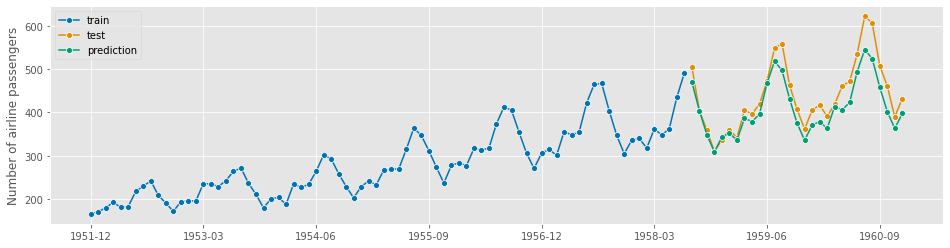

In [139]:
forecaster = AutoETS(error="add", trend="add", seasonal="add", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

Добавим мультипликативный тренд

Forecast error: 0.03091114606762795


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(AMA)   Log Likelihood                -443.033
Date:                          Sat, 05 Feb 2022   AIC                            922.065
Time:                                  19:05:36   BIC                            971.474
Sample:                              01-31-1949   HQIC                           942.120
                                   - 07-31-1958   Scale                          129.935
Covariance Type:                         approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2670      0.044      6.096      0.000       0.181       0.353
smoothing_trend       2.67e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.7329      0.073     10.075      0.000       0.590       0.876
initial_level         107.9520     65.352      1.652      0.099     -20.135     236.039
initial_trend           1.0092        nan        nan        nan         nan         nan
initial_seasonal.0      3.1794     67.773      0.047      0.963    -129.654     136.012
initial_seasonal.1    -13.6671     67.516     -0.202      0.840    -145.997     118.663
initial_seasonal.2      0.5731     66.780      0.009      0.993    -130.312     131.459
initial_seasonal.3     19.2158     66.306      0.290      0.772    -110.743     149.174
initial_seasonal.4     33.1433     66.114      0.501      0.616     -96.438     162.725
initial_seasonal.5     35.2631     66.020      0.534      0.593     -94.134     164.660
initial_seasonal.6     22.6778     66.101      0.343      0.732    -106.879     152.234
initial_seasonal.7      8.2426     66.018      0.125      0.901    -121.150     137.635
initial_seasonal.8     16.7743     66.002      0.254      0.799    -112.587     146.136
initial_seasonal.9     21.8608     65.954      0.331      0.740    -107.406     151.128
initial_seasonal.10     9.1306     66.291      0.138      0.890    -120.797     139.058
initial_seasonal.11          0     66.508          0      1.000    -130.353     130.353
===================================================================================
Ljung-Box (Q):                      145.62   Jarque-Bera (JB):                 2.74
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               7.19   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

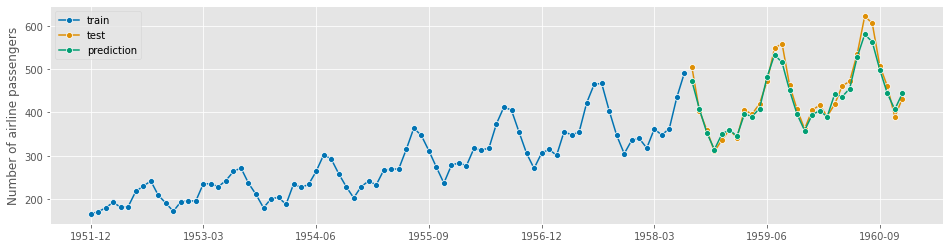

In [138]:
forecaster = AutoETS(error="add", trend="mul", seasonal="add", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

Попробуем ещё мультипликативную сезонность. Видим, что верхние пики стали лучше угадываться, а нижние -- хуже. Качество упало.

Forecast error: 0.041283506277038855


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(AMM)   Log Likelihood                -391.166
Date:                          Sat, 05 Feb 2022   AIC                            818.333
Time:                                  19:05:26   BIC                            867.741
Sample:                              01-31-1949   HQIC                           838.387
                                   - 07-31-1958   Scale                           52.721
Covariance Type:                         approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.087     11.485      0.000       0.829       1.171
smoothing_trend      9.999e-05      0.129      0.001      0.999      -0.253       0.254
smoothing_seasonal   3.853e-05        nan        nan        nan         nan         nan
initial_level         110.9408    321.087      0.346      0.730    -518.379     740.261
initial_trend           1.0093      0.025     39.965      0.000       0.960       1.059
initial_seasonal.0      0.9867      2.856      0.346      0.730      -4.610       6.584
initial_seasonal.1      0.8800      2.547      0.346      0.730      -4.112       5.872
initial_seasonal.2      1.0112      2.927      0.346      0.730      -4.725       6.747
initial_seasonal.3      1.1694      3.385      0.346      0.730      -5.464       7.803
initial_seasonal.4      1.3389      3.875      0.346      0.730      -6.256       8.934
initial_seasonal.5      1.3620      3.942      0.346      0.730      -6.364       9.088
initial_seasonal.6      1.2321      3.566      0.346      0.730      -5.757       8.221
initial_seasonal.7      1.0705      3.098      0.346      0.730      -5.002       7.143
initial_seasonal.8      1.0647      3.081      0.346      0.730      -4.975       7.104
initial_seasonal.9      1.1036      3.194      0.346      0.730      -5.157       7.364
initial_seasonal.10     0.9614      2.782      0.346      0.730      -4.492       6.415
initial_seasonal.11     1.0000      2.894      0.346      0.730      -4.673       6.673
===================================================================================
Ljung-Box (Q):                       35.91   Jarque-Bera (JB):                 3.67
Prob(Q):                              0.04   Prob(JB):                         0.16
Heteroskedasticity (H):               0.80   Skew:                            -0.34
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

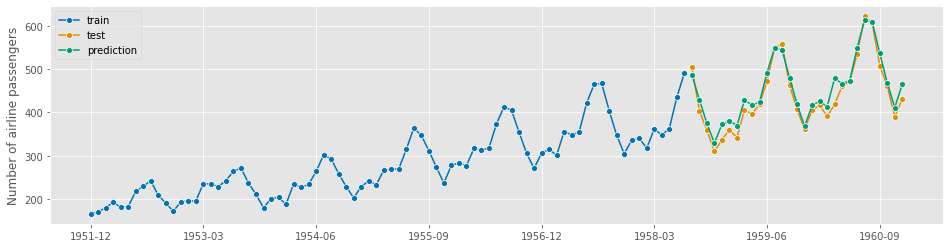

In [137]:
forecaster = AutoETS(error="add", trend="mul", seasonal="mul", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);


print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

Если же сделать не сезонность мультипликативной, а ошибку, то особо ничего не изменится.

Forecast error: 0.032158317166952013


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(MMA)   Log Likelihood                -427.665
Date:                          Sat, 05 Feb 2022   AIC                            891.329
Time:                                  19:38:51   BIC                            940.738
Sample:                              01-31-1949   HQIC                           911.384
                                   - 07-31-1958   Scale                            0.002
Covariance Type:                         approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3003      0.053      5.673      0.000       0.197       0.404
smoothing_trend      3.003e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.6996      0.079      8.823      0.000       0.544       0.855
initial_level         108.2878     54.633      1.982      0.047       1.210     215.366
initial_trend           1.0091      0.001    732.517      0.000       1.006       1.012
initial_seasonal.0      2.5630     56.026      0.046      0.964    -107.246     112.372
initial_seasonal.1    -12.4444     55.895     -0.223      0.824    -121.997      97.108
initial_seasonal.2     -0.6700     55.405     -0.012      0.990    -109.263     107.923
initial_seasonal.3     18.9616     54.944      0.345      0.730     -88.727     126.650
initial_seasonal.4     33.4586     54.760      0.611      0.541     -73.869     140.786
initial_seasonal.5     34.9262     54.851      0.637      0.524     -72.579     142.431
initial_seasonal.6     23.1870     55.189      0.420      0.674     -84.982     131.356
initial_seasonal.7      9.9452     55.272      0.180      0.857     -98.387     118.277
initial_seasonal.8     17.0109     55.177      0.308      0.758     -91.133     125.155
initial_seasonal.9     22.2950     55.019      0.405      0.685     -85.541     130.131
initial_seasonal.10     9.8802     55.276      0.179      0.858     -98.459     118.219
initial_seasonal.11          0     55.168          0      1.000    -108.126     108.126
===================================================================================
Ljung-Box (Q):                      100.28   Jarque-Bera (JB):                 4.04
Prob(Q):                              0.00   Prob(JB):                         0.13
Heteroskedasticity (H):               1.29   Skew:                             0.38
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

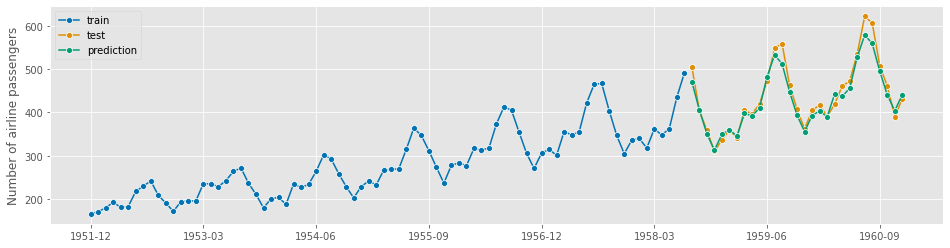

In [147]:
forecaster = AutoETS(error="mul", trend="mul", seasonal="add", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

Forecast error: 0.24946747679262843


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(MAN)   Log Likelihood                -523.580
Date:                          Sat, 05 Feb 2022   AIC                           1057.161
Time:                                  19:11:01   BIC                           1070.886
Sample:                              01-31-1949   HQIC                          1062.732
                                   - 07-31-1958   Scale                            0.010
Covariance Type:                         approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.121      8.233      0.000       0.762       1.238
smoothing_trend  9.999e-05        nan        nan        nan         nan         nan
initial_level     106.6002     11.245      9.480      0.000      84.561     128.640
initial_trend       4.2484      1.581      2.687      0.007       1.150       7.347
===================================================================================
Ljung-Box (Q):                        5.34   Jarque-Bera (JB):                 5.35
Prob(Q):                              0.07   Prob(JB):                         0.07
Heteroskedasticity (H):               1.25   Skew:                             0.15
Prob(H) (two-sided):                  0.49   Kurtosis:                         1.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

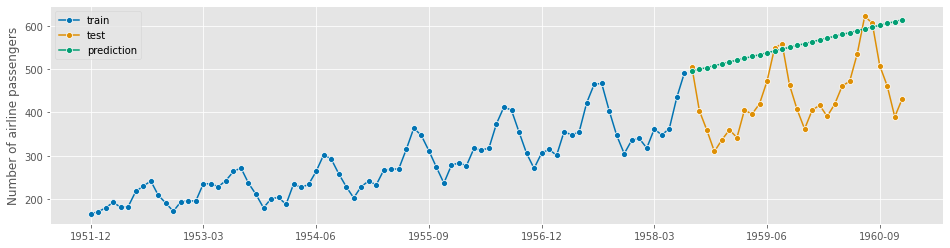

In [146]:
forecaster = AutoETS(auto=True, n_jobs=-1, allow_multiplicative_trend=True )
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

Поработаем немного с наилучшей моделью

Forecast error: 0.03091114606762795


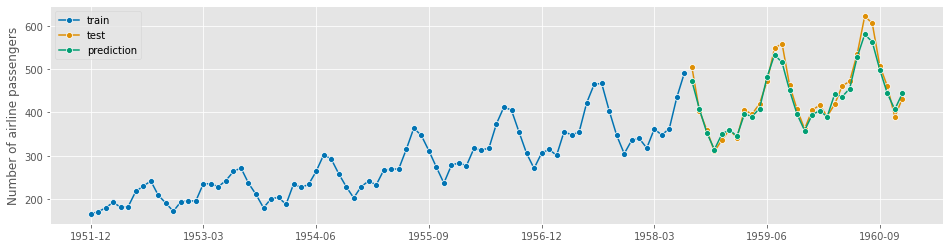

In [158]:
forecaster = AutoETS(error="add", trend="mul", seasonal="add", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);


print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')

Достанем остатки прогнозов этой модели.

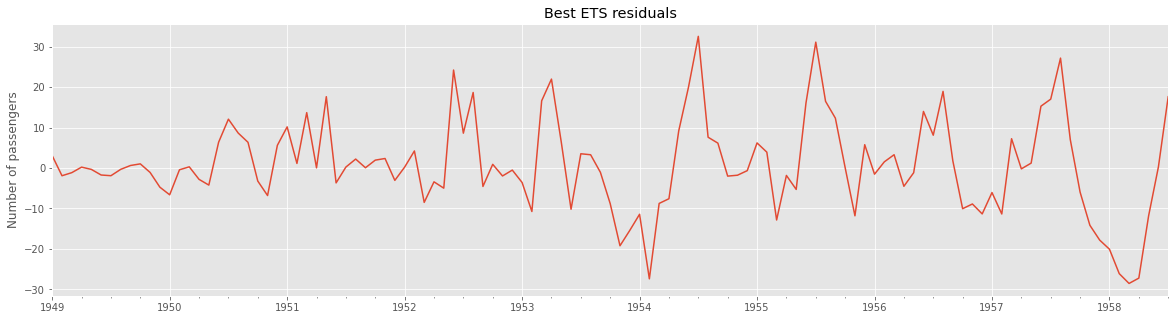

In [164]:
resid = forecaster.predict_residuals()
resid.plot()
plt.title('Best ETS residuals')
plt.ylabel('Number of passengers');

Обычно ещё смотрят на величину остатков. Например, на модуль. Но во многих случаях направление ошибки (недооценка или переоценка модели) может иметь большое значение.

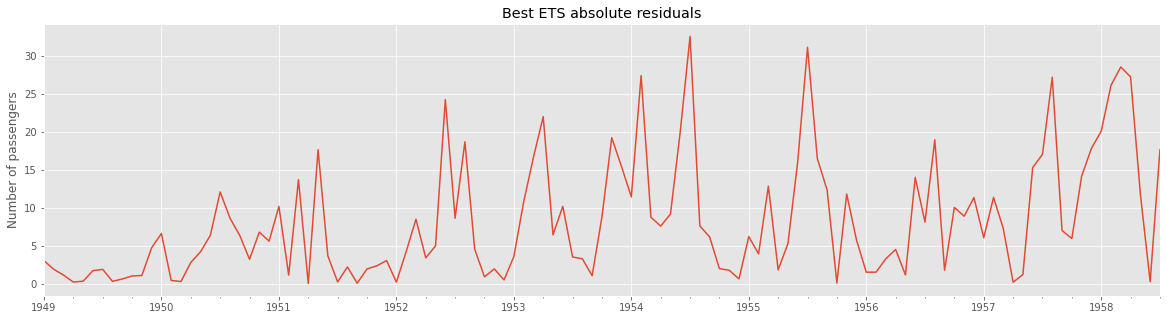

In [167]:
resid.abs().plot()
plt.title('Best ETS absolute residuals')
plt.ylabel('Number of passengers');

Теперь можно попытаться поработать с остатками. Для начала их можно протестировать на наличие линейных взаимосвязей, чтобы понять, аппроксимировали ли мы всю линейную динамику ряда нашей моделью или нет. Если в остатках есть линейные взаимосвязи (а мы их измеряем обычно с помощью автокорреляций или статистических тестов), то наша модель недостаточно хороша. Либо необходимо её улучшить, либо можно построить дополнительную модель. Про тестирование остатков мы поговорим чуть дальше и в частности вы будете этим заниматься во втором ДЗ.

In [ ]:
Временные ряды отличаются некоторой спецификой. Основной проблемой при работе с такими данными является наличие утечек.

![algorithm](images/sem_3_algorithm.png)


In [44]:
from sktime.datasets import load_airline, load_lynx, load_acsf1, load_uschange, load_macroeconomic
from sktime.forecasting.compose._reduce import _RecursiveReducer, _sliding_window_transform
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y = load_airline()